### Import library

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sn
import os
import cv2
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.optimizers import Adadelta, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten, Activation, Dropout, Lambda

### Define local variables

In [2]:
learning_rate = 0.1
min_learning_rate = 0.00001
learning_rate_reduction_factor = 0.5
patience = 3  # how many epochs to wait before reducing the learning rate when the loss plateaus
verbose = 1
image_size = (100, 100)
input_shape = (100, 100, 3)
validation_percent = 0.2
batch_size = 50
epochs = 25

load_model = False
use_label_file = False  # set this to true if you want load the label names from a file; uses the label_file defined below; the file should contain the names of the used labels, each label on a separate line
label_file = 'labels.txt'
base_dir = ''  # relative path to the Fruit-Images-Dataset folder
test_dir = os.path.join(base_dir, 'Test')
train_dir = os.path.join(base_dir, 'Training')
output_dir = 'output_files'  # root folder in which to save the the output files; the files will be under output_files/model_name 
model_name = "fruits model 4"

### Setup output directory

In [3]:
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

### Get class labels of images

In [4]:
if use_label_file:
    with open(label_file, "r") as f:
        labels = [x.strip() for x in f.readlines()]
else:
    labels = os.listdir(train_dir)
num_classes = len(labels)

print(labels)
print(num_classes)

['Apple Braeburn', 'Avocado', 'Blueberry', 'Lemon', 'Orange', 'Pear Forelle']
6


### Prepare data

In [5]:
train_datagen = ImageDataGenerator(
    width_shift_range=0.0,
    height_shift_range=0.0,
    zoom_range=0.0,
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1./255,
    validation_split=validation_percent)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, class_mode='sparse',
                                              batch_size=batch_size, shuffle=True, subset='training', classes=labels)

validation_gen = train_datagen.flow_from_directory(train_dir, target_size=image_size, class_mode='sparse', 
                                                   batch_size=batch_size, shuffle=False, subset='validation', classes=labels)

test_gen = test_datagen.flow_from_directory(test_dir, target_size=image_size, class_mode='sparse',
                                            batch_size=batch_size, shuffle=False, subset=None, classes=labels)

Found 2446 images belonging to 6 classes.
Found 608 images belonging to 6 classes.
Found 1019 images belonging to 6 classes.


#### Show an image from train data

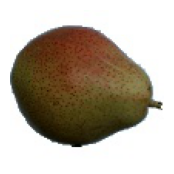

In [6]:
img = train_gen.__getitem__(5)[0][0]
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(2, 2))
plt.axis("off")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

### Construct model (CNN)

In [7]:
def network(input_shape, num_classes):
    img_input = Input(shape=input_shape, name='data')
    x = img_input
    x = Conv2D(16, (5, 5), strides=(1, 1), padding='same', name='conv1')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool1')(x)
    x = Conv2D(32, (5, 5), strides=(1, 1), padding='same', name='conv2')(x)
    x = Activation('relu', name='conv2_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool2')(x)
    x = Conv2D(64, (5, 5), strides=(1, 1), padding='same', name='conv3')(x)
    x = Activation('relu', name='conv3_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool3')(x)
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='same', name='conv4')(x)
    x = Activation('relu', name='conv4_relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), padding='valid', name='pool4')(x)
    x = Flatten()(x)
    x = Dense(1024, activation='relu', name='fcl1')(x)
    x = Dropout(0.2)(x)
    x = Dense(256, activation='relu', name='fcl2')(x)
    x = Dropout(0.2)(x)
    out = Dense(num_classes, activation='softmax', name='predictions')(x)
    rez = Model(inputs=img_input, outputs=out)
    return rez

model = network(input_shape=input_shape, num_classes=num_classes)
print(model.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
data (InputLayer)            [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 100, 100, 16)      1216      
_________________________________________________________________
conv1_relu (Activation)      (None, 100, 100, 16)      0         
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 50, 50, 16)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 50, 50, 32)        12832     
_________________________________________________________________
conv2_relu (Activation)      (None, 50, 50, 32)        0         
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 25, 25, 32)        0     

#### Setup model output directory

In [8]:
model_out_dir = os.path.join(output_dir, model_name)

if not os.path.exists(model_out_dir):
    os.makedirs(model_out_dir)

### Model training

In [9]:
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', patience=patience, verbose=verbose, 
                                            factor=learning_rate_reduction_factor, min_lr=min_learning_rate)

save_model = ModelCheckpoint(filepath=model_out_dir + "/model.h5", monitor='val_accuracy', verbose=verbose, 
                             save_best_only=True, save_weights_only=False, mode='max', period=1)

history = model.fit(train_gen,
                    epochs=epochs,
                    steps_per_epoch=(train_gen.n // batch_size) + 1,
                    validation_data=validation_gen,
                    validation_steps=(validation_gen.n // batch_size) + 1,
                    verbose=verbose,
                    callbacks=[learning_rate_reduction, save_model])

Epoch 1/25
49/49 [==============================] - 9s 103ms/step - loss: 0.5366 - accuracy: 0.7911 - val_loss: 0.2787 - val_accuracy: 0.9424

Epoch 00001: val_accuracy improved from -inf to 0.94243, saving model to output_files\fruits model 4\model.h5
Epoch 2/25
49/49 [==============================] - 4s 78ms/step - loss: 0.0237 - accuracy: 0.9918 - val_loss: 0.0031 - val_accuracy: 1.0000

Epoch 00002: val_accuracy improved from 0.94243 to 1.00000, saving model to output_files\fruits model 4\model.h5
Epoch 3/25
49/49 [==============================] - 4s 79ms/step - loss: 3.9555e-04 - accuracy: 1.0000 - val_loss: 1.9689e-05 - val_accuracy: 1.0000

Epoch 00003: val_accuracy did not improve from 1.00000
Epoch 4/25
49/49 [==============================] - 4s 78ms/step - loss: 6.4313e-05 - accuracy: 1.0000 - val_loss: 5.7008e-06 - val_accuracy: 1.0000

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/25
49/49 [==============================] - 4s 82ms/step - loss: 3.8712e-0

### Save model

In [10]:
model.save(model_out_dir + "/model.h5")

### Load model

In [11]:
if load_model:
    model = tf.keras.models.load_model(model_out_dir + "/model.h5")

### Model evaluation

#### Validation and Test result

In [12]:
validation_gen.reset()

loss_v, accuracy_v = model.evaluate(validation_gen, steps=(validation_gen.n // batch_size) + 1, verbose=verbose)
loss, accuracy = model.evaluate(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=verbose)
print("Validation: accuracy = %f  ;  loss = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

21/21 [==============================] - 1s 56ms/step - loss: 0.0248 - accuracy: 0.9863
Validation: accuracy = 1.000000  ;  loss = 0.000001
Test: accuracy = 0.986261  ;  loss = 0.024842


#### Accuracy plot

In [13]:
axs[0].plot(range(1, len(history.history['accuracy']) + 1), history.history['accuracy'])
axs[0].plot(range(1, len(history.history['val_accuracy']) + 1), history.history['val_accuracy'])
axs[0].set_title('Model Accuracy')
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].legend(['train', 'val'], loc='best')

#### Loss plot

In [14]:
axs[1].plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
axs[1].plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('Loss')
axs[1].set_xlabel('Epoch')
axs[1].legend(['train', 'val'], loc='best')

#### Plot & Save

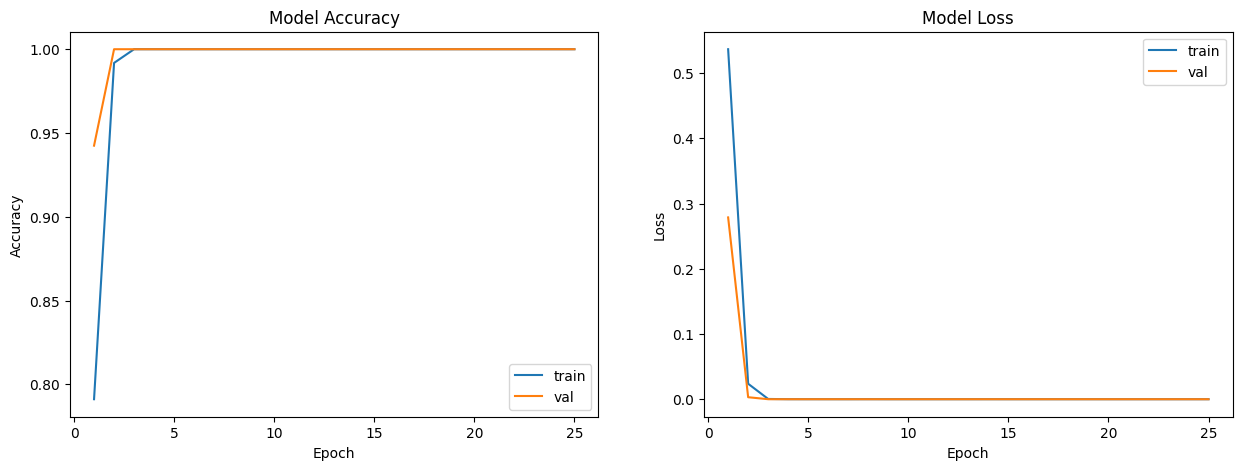

In [15]:
if model_out_dir:
    plt.savefig(model_out_dir + "/acc_loss.png")

plt.show()

#### Confusion matrix

21/21 [==============================] - 1s 42ms/step


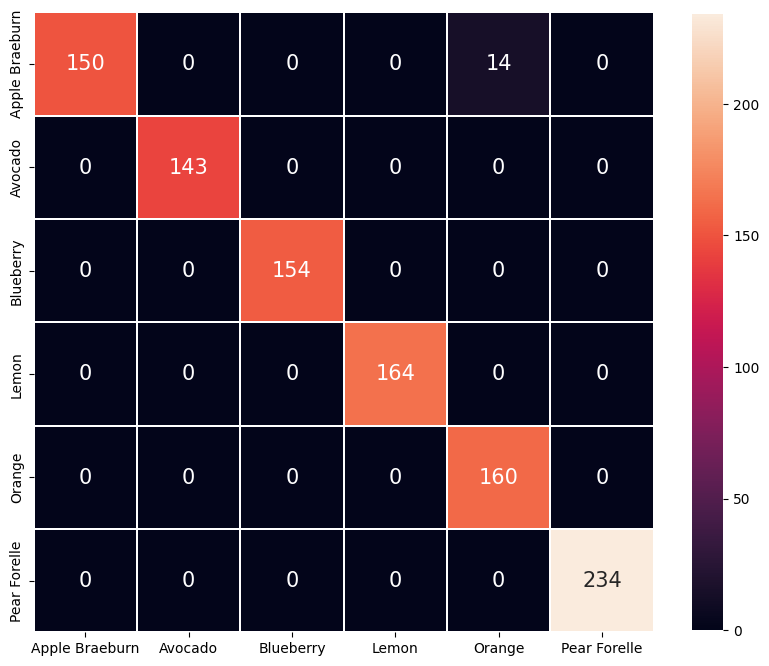

In [16]:
test_gen.reset()

y_pred = model.predict(test_gen, steps=(test_gen.n // batch_size) + 1, verbose=verbose)
y_true = test_gen.classes[test_gen.index_array]

cm = confusion_matrix(y_true, y_pred.argmax(axis=-1))
df_cm = pd.DataFrame(cm, index=[i for i in labels], columns=[i for i in labels])
plt.figure(figsize=(10, 10))
ax = sn.heatmap(df_cm, annot=True, square=True, fmt="d", linewidths=.2, cbar_kws={"shrink": 0.8}, annot_kws={'size': 15})

if model_out_dir:
    plt.savefig(model_out_dir + "/confusion_matrix.png")  # as in the plot_model_history, the matrix is saved in a file called "model_name_confusion_matrix.png"

plt.show()

#### Show misclassified images

In [17]:
batch_num = (test_gen.n // batch_size) + 1
test_img = np.empty(shape=(test_gen.n, 100, 100, 3), dtype=np.float32)
 
img_num = 0
for b in range(batch_num):
    for i in range((test_gen.__getitem__(b)[0]).shape[0]):
        test_img[img_num] = test_gen.__getitem__(b)[0][i]
        img_num += 1

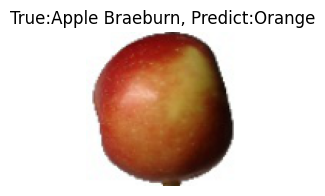

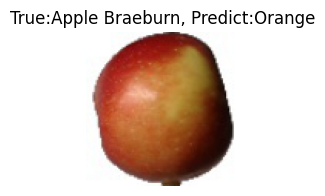

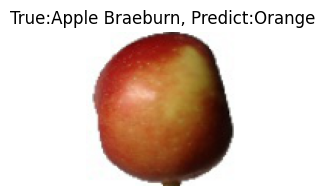

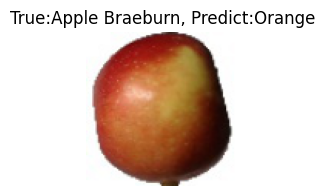

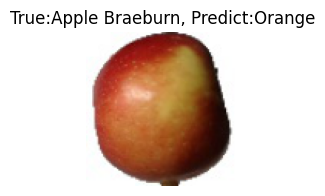

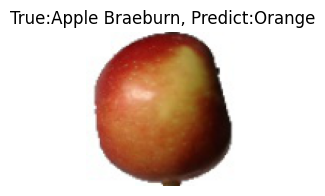

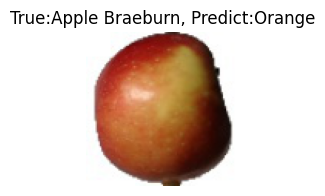

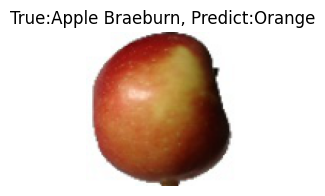

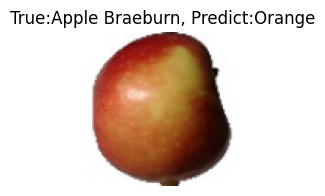

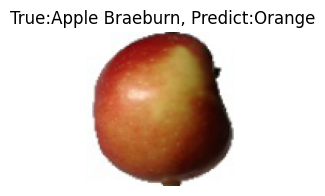

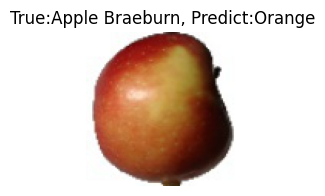

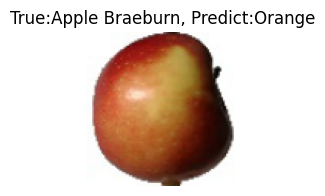

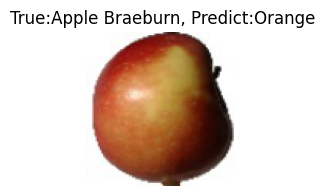

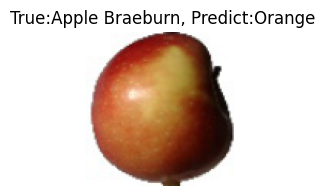

In [18]:
for i, (true, pred) in enumerate(zip(y_true, y_pred.argmax(axis=-1))):
    if pred != true:
        img = test_img[i]
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(2, 2))
        plt.axis("off")
        plt.title("True:{}, Predict:{}".format(labels[true], labels[pred]))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()

#### Classification report

In [19]:
class_report = classification_report(y_true, y_pred.argmax(axis=-1), target_names=labels)

with open(model_out_dir + "/classification_report.txt", "w") as text_file:
    text_file.write("%s" % class_report)

print(class_report)

                precision    recall  f1-score   support

Apple Braeburn       1.00      0.91      0.96       164
       Avocado       1.00      1.00      1.00       143
     Blueberry       1.00      1.00      1.00       154
         Lemon       1.00      1.00      1.00       164
        Orange       0.92      1.00      0.96       160
  Pear Forelle       1.00      1.00      1.00       234

      accuracy                           0.99      1019
     macro avg       0.99      0.99      0.99      1019
  weighted avg       0.99      0.99      0.99      1019

